In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import iqr

import os
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import datetime
import calendar

from numpy import mean
from numpy import std

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

import joblib

In [2]:
names = ['Class', 'Alcohol', 'Acid', 'Ash', 'Alcalinity', 'Magnesium', 
         'TotPhenols', 'Flavanoids', 'NonflavPhenols', 'Proanth', 'ColIntensity', 
         'Hue', 'OD', 'Proline']
wine = pd.read_csv('wine.data',header = None, names = names)
print(wine.shape)
wine.head(2)

(178, 14)


,Class,Alcohol,Acid,Ash,Alcalinity,Magnesium,TotPhenols,Flavanoids,NonflavPhenols,Proanth,ColIntensity,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050


In [3]:
def print_unique(df):
    for col in df.columns:
        print(col, '\n', df[col].sort_values().unique(), '\n')
        
print_unique(wine)

Class 
 [1 2 3] 

Alcohol 
 [11.03 11.41 11.45 11.46 11.56 11.61 11.62 11.64 11.65 11.66 11.76 11.79
 11.81 11.82 11.84 11.87 11.96 12.   12.04 12.07 12.08 12.16 12.17 12.2
 12.21 12.22 12.25 12.29 12.33 12.34 12.36 12.37 12.42 12.43 12.45 12.47
 12.51 12.52 12.53 12.58 12.6  12.64 12.67 12.69 12.7  12.72 12.77 12.79
 12.81 12.82 12.84 12.85 12.86 12.87 12.88 12.93 12.96 12.99 13.03 13.05
 13.07 13.08 13.11 13.16 13.17 13.2  13.23 13.24 13.27 13.28 13.29 13.3
 13.32 13.34 13.36 13.39 13.4  13.41 13.45 13.48 13.49 13.5  13.51 13.52
 13.56 13.58 13.62 13.63 13.64 13.67 13.68 13.69 13.71 13.72 13.73 13.74
 13.75 13.76 13.77 13.78 13.82 13.83 13.84 13.86 13.87 13.88 13.9  13.94
 14.02 14.06 14.1  14.12 14.13 14.16 14.19 14.2  14.21 14.22 14.23 14.3
 14.34 14.37 14.38 14.39 14.75 14.83] 

Acid 
 [0.74 0.89 0.9  0.92 0.94 0.98 0.99 1.01 1.07 1.09 1.1  1.13 1.17 1.19
 1.21 1.24 1.25 1.29 1.33 1.34 1.35 1.36 1.39 1.41 1.43 1.45 1.47 1.48
 1.5  1.51 1.52 1.53 1.57 1.59 1.6  1.61 1.63 1.64 1.65 

In [4]:
def get_snapshot(df):
    n_missing = pd.DataFrame(df.isnull().sum(), columns = ['n_missing'])
    pct_missing = pd.DataFrame(round(df.isnull().sum() / df.shape[0], 2), columns = ['pct_missing'])
    dtype = pd.DataFrame(df.dtypes, columns = ['dtype'])
    n_unique = []
    for col in df.columns:
        n_unique.append(df[col].nunique())    
    return pd.DataFrame(n_unique, index = df.columns, columns = ['n_unique']).join(dtype).join(n_missing).join(pct_missing)

In [5]:
snapshot = get_snapshot(wine)
snapshot

,n_unique,dtype,n_missing,pct_missing
Class,3,int64,0,0.0
Alcohol,126,float64,0,0.0
Acid,133,float64,0,0.0
Ash,79,float64,0,0.0
Alcalinity,63,float64,0,0.0
Magnesium,53,int64,0,0.0
TotPhenols,97,float64,0,0.0
Flavanoids,132,float64,0,0.0
NonflavPhenols,39,float64,0,0.0
Proanth,101,float64,0,0.0


In [6]:
np.sort(snapshot['n_unique'].unique())

array([  3,  39,  53,  63,  78,  79,  97, 101, 121, 122, 126, 132, 133],
      dtype=int64)

In [7]:
features = wine.columns.drop('Class')

In [8]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (4, 4))
    df[col].value_counts().plot.bar(color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    
    plt.xticks(rotation = 0)
    plt.grid()
    plt.title(col)
    plt.show()

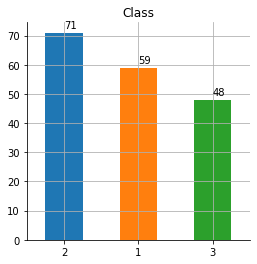

In [9]:
plot_single_categorical(wine, 'Class')

In [12]:
wine_dummies = pd.get_dummies(wine, columns = ['Class'], dtype = int).join(wine['Class'])

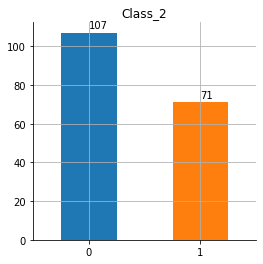

In [13]:
plot_single_categorical(wine_dummies, 'Class_2')

In [14]:
def feat_significance(X, y, n_feat_data_type, features):
    mi_df = pd.DataFrame(mutual_info_classif(X, y, random_state = 42), index = X.columns, columns = ['score'])
    mi_df = mi_df.sort_values(by = 'score', ascending = False)
    
    def color_cell(s):    
        background = []
        for i in range(len(s.index)):
            if s.index[i] in features:
                background.append('background-color: yellow')
            else:
                background.append('')
        return background
    
    if n_feat_data_type == 1:
        return mi_df
    else:
        return mi_df.style.apply(color_cell, axis = 0)

In [17]:
feat_score = feat_significance(wine_dummies[features], wine_dummies['Class_2'], 1, '')
feat_score

,score
ColIntensity,0.467287
Alcohol,0.382546
Proline,0.264228
Flavanoids,0.251295
Magnesium,0.148977
Hue,0.125271
OD,0.108222
Acid,0.091624
TotPhenols,0.062771
Proanth,0.061406


In [18]:
def get_mean_std(df):
    mean_col = pd.DataFrame(df.mean(), columns = ['mean'])
    std_col = pd.DataFrame(df.std(), columns = ['std'])
    mean_plus_std = mean_col.join(std_col)
    return mean_plus_std

In [19]:
get_mean_std(wine_dummies[features])

,mean,std
Alcohol,13.000618,0.811827
Acid,2.336348,1.117146
Ash,2.366517,0.274344
Alcalinity,19.494944,3.339564
Magnesium,99.741573,14.282484
TotPhenols,2.295112,0.625851
Flavanoids,2.029270,0.998859
NonflavPhenols,0.361854,0.124453
Proanth,1.590899,0.572359
ColIntensity,5.058090,2.318286


In [20]:
X_scaled = pd.DataFrame(scale(wine_dummies[features]), columns = features)
y = wine_dummies['Class_2']

In [21]:
lr = LogisticRegression(random_state = 42)
knn = KNeighborsClassifier()
svc = SVC(random_state = 42)
tree = DecisionTreeClassifier(max_features = 'auto', random_state = 42)
alg_dict = {lr: 'lr', svc: 'svc', knn: 'knn', tree: 'tree'}

In [22]:
def num_feat_perform(algorithm, feat_ordered, X_ordered, y, metric):
    scores = []
    for i in range(1, len(feat_ordered)+1):
        pred_data = X_ordered.iloc[:, 0:i]
        score = mean(cross_val_score(algorithm, pred_data, y, scoring = metric, cv = 5))
        scores.append(score)

    n_features = len(feat_ordered)
    plt.plot(np.arange(n_features), scores, marker = 'x')
    plt.xticks(np.arange(n_features), np.arange(1, n_features + 1))
    for i in range(n_features):
        plt.text(i, scores[i], s = round(scores[i], 2))
    plt.grid()
    plt.xlabel('no. of features')
    plt.ylabel('score')
    
def num_feat_multi_alg(alg_dict, feat_ordered, X_ordered, y, metric):
    n_algorithm = len(alg_dict)
    algorithms = list(alg_dict.keys())
    alg_names = list(alg_dict.values())
    if n_algorithm <= 2:
        nrows = 1
        ncols = n_algorithm
        fig = plt.figure(figsize = (ncols * 6, 4))
    else:
        nrows = math.ceil(n_algorithm / 2)
        ncols = 2
        fig = plt.figure(figsize = (12, nrows * 4))

    for n in range(n_algorithm):
        ax = fig.add_subplot(nrows, ncols, n + 1)
        ax = num_feat_perform(algorithms[n], feat_ordered, X_ordered, y, metric)
        plt.title(f"'{alg_names[n]}' performance by '{metric}'")
        
    plt.tight_layout()
    plt.show()

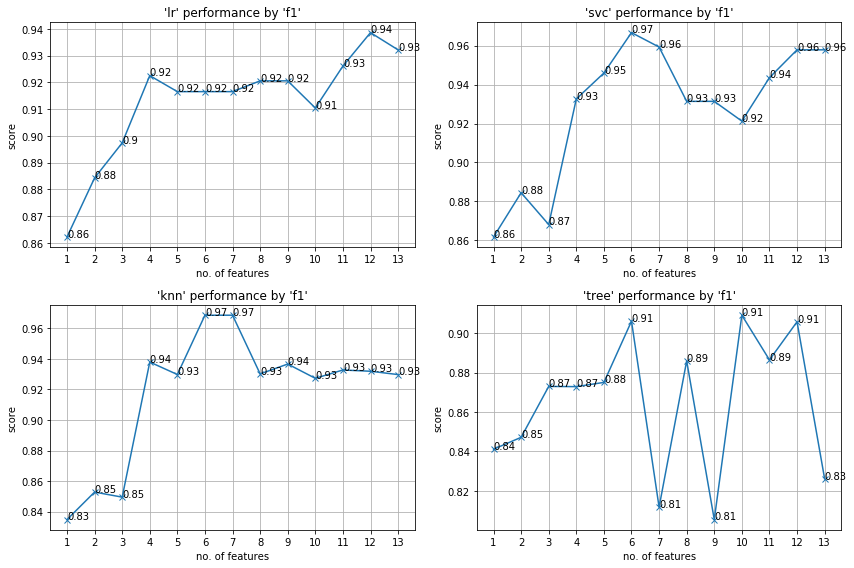

In [23]:
num_feat_multi_alg(alg_dict, feat_score.index, X_scaled[feat_score.index], y, 'f1')

In [28]:
feat_svc = feat_score.index[0:6]
feat_svc

Index(['ColIntensity', 'Alcohol', 'Proline', 'Flavanoids', 'Magnesium', 'Hue'], dtype='object')

In [25]:
def plot_learning_curve(train_scores, test_scores, train_sizes):
    train_scores = pd.DataFrame(train_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    train_scores = train_scores.join(pd.Series(train_scores.mean(axis = 1), name = 'mean'))

    test_scores = pd.DataFrame(test_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    test_scores = test_scores.join(pd.Series(test_scores.mean(axis = 1), name = 'mean'))

    plt.plot(train_scores['mean'], label = 'train_scores')
    plt.plot(test_scores['mean'], label = 'test_scores')
    plt.legend()
    plt.grid()
    plt.xlabel('no. of training samples')
    
def two_metric_graph(algorithm, X, y):
    train_sizes = np.linspace(start = 20, stop = X.shape[0] * 0.8, num = 6, dtype = int)
    fig = plt.figure(figsize = (10, 4))

    for i, metric in enumerate(['f1', 'balanced_accuracy']):
        train_sizes_abs, train_scores, test_scores = learning_curve(algorithm, X, y, train_sizes = train_sizes, 
                                                                    scoring = metric, cv = 5, shuffle = True, 
                                                                    random_state = 42)
        ax = fig.add_subplot(1, 2, i + 1)
        ax = plot_learning_curve(train_scores, test_scores, train_sizes)
        plt.title(f"'performance by '{metric}'")

    plt.tight_layout()
    plt.show()

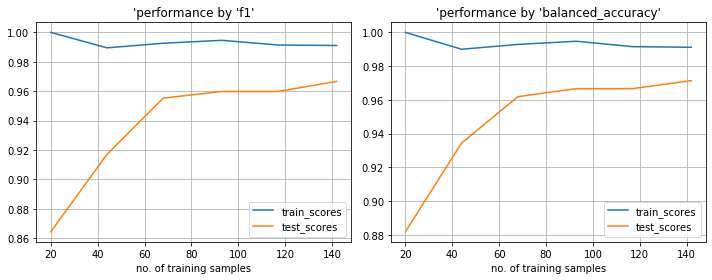

In [30]:
two_metric_graph(svc, X_scaled[feat_svc], y)

In [31]:
svc.fit(X_scaled[feat_svc], y)
joblib.dump(svc, 'svc.joblib')

['svc.joblib']